## 8.1 Convolutional neural networks CNN

As we discussed in the last chapter, we could augment our
training data by using a wide variety of recropped images to try to force generalization, but that won’t address the issue of having too many parameters

 There is a better way! It consists of replacing the dense, fully connected affine transformation in our neural network unit with a different linear operation: convolution

 Note that, just like the elements in the weight matrix of nn.Linear, the weights in
the kernel are not known in advance, but they are initialized randomly and updated
through backpropagation

Note also that the same kernel, and thus each weight in the
kernel, is reused across the whole image. Thinking back to autograd, this means the use
of each weight has a history spanning the entire image. Thus, the derivative of the loss
with respect to a convolution weight includes contributions from the entire image.

with a convolution layer, the number of parameters depends not on the number of pixels in the image, as was the case
in our fully connected model, but rather on the size of the convolution kernel (3 × 3,
5 × 5, and so on) and on how many convolution filters (or output channels) we decide
to use in our model.

### 8.2 Convolutions in action


e. The torch.nn module provides convolutions for 1, 2, and 3 dimensions: nn.Conv1d for time series, nn.Conv2d for images,
and nn.Conv3d for volumes or videos

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [1]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [2]:
from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

100%|██████████| 170498071/170498071 [04:32<00:00, 625613.51it/s] 


Extracting ../data-unversioned/p1ch6/cifar-10-python.tar.gz to ../data-unversioned/p1ch6/


In [3]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [4]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [8]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [9]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

#### start of book code

In [14]:
conv = nn.Conv2d(3, 16, kernel_size=3)# kernel size 3 is 3x3
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

so the complete weight tensor is out_ch × in_ch × 3 × 3, in our case
16 × 3 × 3 × 3.

In [15]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

A 2D convolution pass produces a 2D image as output, whose pixels are a weighted
sum over neighborhoods of the input image. In our case, both the kernel weights and    the bias conv.weight are initialized randomly, so the output image will not be particularly meaningful.

 if we want to call the conv module with one input image, since nn.Conv2d
expects a B × C × H × W shaped tensor as input

In [16]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

We’re curious, so we can display the output,

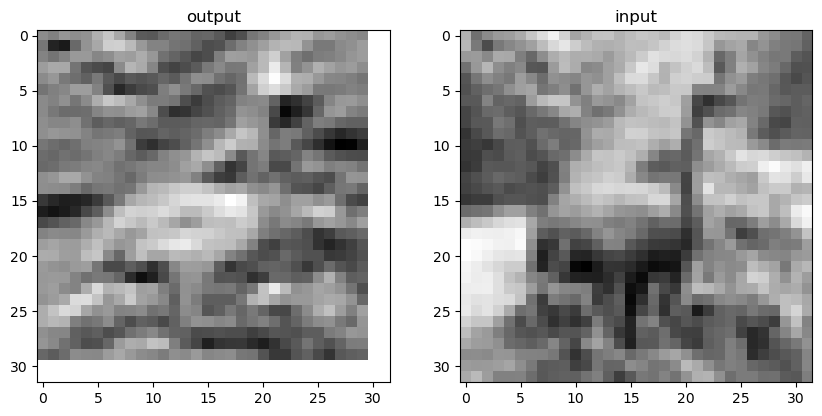

In [22]:
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

### 8.2.1 Padding the boundary



pošto kerneli moraju imat sve pixele nemaju ih na rubovima, zato smo tu izgubili pixele, vidi prvu sliku<br>However, PyTorch gives us the possibility of padding the image by creating ghost pixels around the border that have value zero as far as the convolution is concerned. Figure 8.3 shows padding in action

In [23]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1) # DODALI SMO PADDING
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

We said earlier that weight and bias are parameters that are learned through backpropagation, exactly as it happens for weight and bias in nn.Linear. However, we can
play with convolution by setting weights by hand and see what happens.
 Let’s first zero out bias, just to remove any confounding factors, and then set
weights to a constant value so that each pixel in the output gets the mean of its neighbors. For each 3 × 3 neighborhood:

In [24]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

introduction to kernels was at https://github.com/nivagion/Image-operations

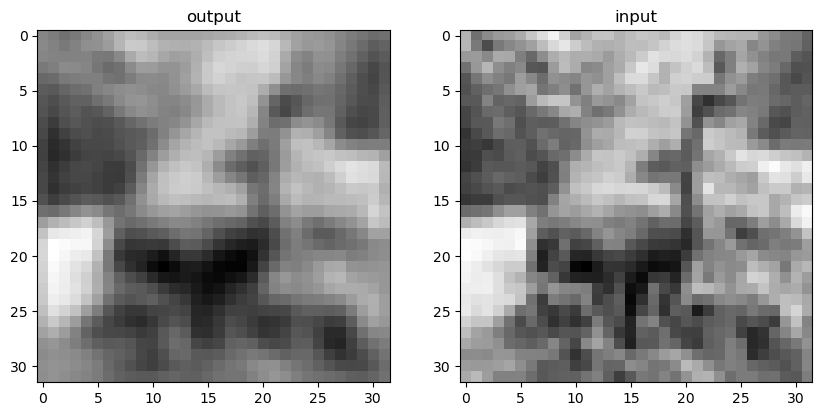

In [25]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

OTHER PADDING, ABOVE WAS AVERAGING PIXELS AND MAKING IT BLURRY

In [27]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

It’s an edge-detection kernel: the kernel highlights the
vertical edge between two horizontally adjacent regions

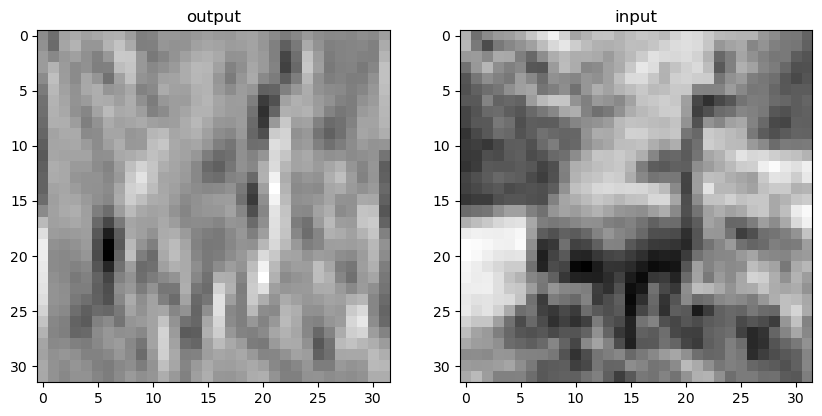

In [28]:
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F5_PyTorch.png')  # bookskip
plt.show()

dakle kao što postoje kerneli za edge detecting, blurring, etc, cilj CNNa je da nađe neke karakteristike na slikama i da automatski napravi te kernele, pogledaj sliku 8.6

### 8.2.3 Looking further with depth and pooling


 Max pooling is provided by the nn.MaxPool2d module (as with convolution, there are
versions for 1D and 3D data)

In [29]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

COMBINING CONVOLUTIONS AND DOWNSAMPLING FOR GREAT GOOD

#### 8.2.4 Putting it all together for our network


In [30]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

The first convolution takes us from 3 RGB channels to 16, thereby giving the network
a chance to generate 16 independent features that operate to (hopefully) discriminate low-level features of birds and airplanes. Then we apply the Tanh activation function. The resulting 16-channel 32 × 32 image is pooled to a 16-channel 16 × 16 image
by the first MaxPool3d. At this point, the downsampled image undergoes another convolution that generates an 8-channel 16 × 16 output. With any luck, this output will
consist of higher-level features. Again, we apply a Tanh activation and then pool to an
8-channel 8 × 8 output.
 Where does this end? After the input image has been reduced to a set of 8 × 8 features, we expect to be able to output some probabilities from the network that we can
feed to our negative log likelihood. However, probabilities are a pair of numbers in a
1D vector (one for airplane, one for bird), but here we’re still dealing with multichannel 2D features.

turn the 8-channel 8 × 8 image into a 1D vector and complete our network with a
set of fully connected layers

In [31]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... <1> somethings missing
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [32]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

 What’s missing there is the reshaping step from an 8-channel 8 × 8 image to a 512-
element, 1D vector (1D if we ignore the batch dimension, that is)

### 8.3 Subclassing nn.Module

So in this section, we learn how to make our own
nn.Module subclasses that we can then use just like the prebuilt ones or nn.Sequential.

To include these submodules, we typically define them in the constructor
__init__ and assign them to self for use in the forward function. They will, at the
same time, hold their parameters throughout the lifetime of our module

### 8.3.1 Our network as an nn.Module


In [33]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # <1> we were missing this reshape earier
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

The Net class is equivalent to the nn.Sequential model
we built earlier in terms of submodules; but by writing
the forward function explicitly, we can manipulate the
output of self.pool3 directly and call view on it to turn
it into a B × N vector

So the first layer is exceptional in that it greatly increases the overall dimension (as in
channels times pixels) of the data flowing through it, but the mapping for each output pixel considered in isolation still has approximately as many outputs as inputs

We can call arbitrary methods of an nn.Module subclass. For example, for a model
where training is substantially different than its use, say, for prediction, it may make
sense to have a predict method. Be aware that calling such methods will be similar to
calling forward instead of the module itself—they will be ignorant of hooks, and the
JIT does not see the module structure when using them because we are missing the
equivalent of the __call__ bits shown in section 6.2.1.

In [34]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

looking back at the implementation of the Net class, and thinking about the
utility of registering submodules in the constructor so that we can access their parameters, it appears a bit of a waste that we are also registering submodules that have no
parameters, like nn.Tanh and nn.MaxPool2d. Wouldn’t it be easier to call these
directly in the forward function, just as we called view?

### 8.3.3 The functional API


 Back to our model, it makes sense to keep using nn modules for nn.Linear and
nn.Conv2d so that Net will be able to manage their Parameters during training. However, we can safely switch to the functional counterparts of pooling and activation,
since they have no parameters:

In [35]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Thus, the functional way also sheds light on what the nn.Module API is all about: a
Module is a container for state in the forms of Parameters and submodules combined
with the instructions to do a forward

. When part of a network is so simple that we want to use nn.Sequential, we’re in
the modular realm

In [36]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1272, -0.1751]], grad_fn=<AddmmBackward0>)

We might not realize it right now,
but in more complex models, getting the size of the first linear layer right is sometimes a source of frustration. We’ve heard stories of famous practitioners putting in
arbitrary numbers and then relying on error messages from PyTorch to backtrack the
correct sizes for their linear layers. Lame, eh? Nah, it’s all legit!

### 8.4 Training our convnet


after we run our model, we will also have an appetite for a little more
speed, so we will learn how to run our models fast on a GPU. But first let’s look at the
training loop

Recall that the core of our convnet is two nested loops: an outer one over the
epochs and an inner one of the DataLoader that produces batches from our Dataset.
In each loop, we then have to<br>
1 Feed the inputs through the model (the forward pass).<br>
2 Compute the loss (also part of the forward pass).<br>
3 Zero any old gradients.<br>
4 Call loss.backward() to compute the gradients of the loss with respect to all
parameters (the backward pass).<br>
5 Have the optimizer take a step in toward lower loss.<br>
Also, we collect and print some information.

In [37]:
import datetime  # <1>Uses the datetime module included with Python

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>Our loop over the epochs, numbered from 1 to n_epochs rather than starting at 0
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>Loops over our dataset in the batches the data loader creates for us
            
            outputs = model(imgs)  # <4>Feeds a batch through our model …
            
            loss = loss_fn(outputs, labels)  # <5>and computes the loss we wish to optimize

            optimizer.zero_grad()  # <6> After getting rid of gradients from the last round …
            
            loss.backward()  # <7>… performs the backward step. That is, we  compute the gradients 
                             # of all parameters we want network to learn on
            
            optimizer.step()  # <8> updates the model

            loss_train += loss.item()  # <9>Sums the losses we saw over the epoch. Recall that it is important to transform the
                                       #  loss to a Python number with .item(), to escape the gradients.

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # Divides by the length of the training data loader to get the average loss
                                                  # per batch. This is a much more intuitive measure than the sum.

The substantial changes in our model from the last chapter are that now our
model is a custom subclass of nn.Module and that we’re using convolutions. Let’s run
training for 100 epochs while printing the loss. Depending on your hardware, this
may take 20 minutes or more to finish!

In [38]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,shuffle=True)  
# 1 The DataLoader batches up the examples of our cifar2 dataset. Shuffling randomizes the order of the examples from the dataset.

model = Net()  #  <2> Instantiates our network
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3> the stochastic gradient descent optimizer we have been working with
loss_fn = nn.CrossEntropyLoss()  #  <4> and the cross entropy we met in 7.10

training_loop(  # <5>
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-08-02 04:45:53.262580 Epoch 1, Training loss 0.5926206123297382
2024-08-02 04:46:22.528988 Epoch 10, Training loss 0.3374404472530268
2024-08-02 04:46:55.746647 Epoch 20, Training loss 0.29991124560878535
2024-08-02 04:47:29.699532 Epoch 30, Training loss 0.2743233172756851
2024-08-02 04:48:01.777773 Epoch 40, Training loss 0.2515154022984444
2024-08-02 04:48:33.425414 Epoch 50, Training loss 0.2309745597611567
2024-08-02 04:49:05.833712 Epoch 60, Training loss 0.21376993013605192
2024-08-02 04:49:37.413830 Epoch 70, Training loss 0.19832266553951677
2024-08-02 04:50:09.546007 Epoch 80, Training loss 0.183595192019537
2024-08-02 04:50:41.841588 Epoch 90, Training loss 0.17164720566409408
2024-08-02 04:51:14.454133 Epoch 100, Training loss 0.15934193333622756


### 8.4.1 Measuring accuracy

In [39]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1> We do not want gradients here, as we will not want to update the parameters
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2> Gives us the index of the highest value as output
                total += labels.shape[0]  # <3> Counts the number of examples, so total is increased by the batch size
                correct += int((predicted == labels).sum())  # Comparing the predicted class that had the maximum probability
                # and the ground-truth labels, we first get a Boolean array. Taking the sum gives the number of items in the batch 
                # where the prediction and ground truth agree.

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.90


This is quite a lot better than the fully connected model, which achieved only 79%
accuracy. We about halved the number of errors on the validation set. Also, we used
far fewer parameters. This is telling us that the model does a better job of generalizing
its task of recognizing the subject of images from a new sample, through locality and
translation invariance. We could now let it run for more epochs and see what performance we could squeeze out. 

### 8.4.2 Saving and loading our model


In [40]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

The birds_vs_airplanes.pt file now contains all the parameters of model: that is,
weights and biases for the two convolution modules and the two linear modules. So, no structure—just the weights. This means when we deploy the model in production
for our friend, we’ll need to keep the model class handy, create an instance, and then
load the parameters back into it:

In [41]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

### 8.4.3 Training on the GPU

In [44]:
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))
print(f"Training on device {device}.")

Training on device cpu.


Then we can amend the training loop by moving the tensors we get from the data
loader to the GPU by using the Tensor.to method. Note that the code is exactly like
our first version at the beginning of this section except for the two lines moving the
inputs to the GPU

In [45]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # <1> These two lines that move imgs and labels to the device we are 
                                            # training on are the only difference from our previous version
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

MARK <1> below <br>Moves our model (all parameters) to the GPU. If you forget to move either the model or the inputs to the GPU, you will get errors about tensors not being on the same device, because the PyTorch operators do not support mixing GPU and CPU inputs.

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # <1>
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

As we don’t know whether we want the same device, we
have two options: we could move the network to the CPU before saving it, or move it
back after restoring. It is a bit more concise to instruct PyTorch to override the device
information when loading weights. This is done by passing the map_location keyword
argument to torch.load:

In [47]:
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

<All keys matched successfully>

### 8.5 Model design

PyTorch ships with a very comprehensive collection of modules and loss functions
to implement state-of-the-art architectures ranging from feed-forward components to
long short-term memory (LSTM) modules and transformer networks (two very popular architectures for sequential data). Several models are available through PyTorch
Hub or as part of torchvision and other vertical community efforts.

### 8.5.1 Adding memory capacity: Width


We just specify a larger number of
output channels in the first convolution and increase the subsequent layers accordingly, taking care to change the forward function to reflect the fact that we’ll now
have a longer vector once we switch to fully connected layers:

#### WIDTH

In [48]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 16 * 8 * 8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

validate(model, train_loader, val_loader) #DIDNT RUN THIS

If we want to avoid hardcoding numbers in the definition of the model, we can easily
pass a parameter to init and parameterize the width, taking care to also parameterize
the call to view in the forward function

#### WIDTH initialized

In [50]:
class NetWidth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetWidth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader) # DIDNT RUN THIS ONE

In [53]:
sum(p.numel() for p in model.parameters())

38386

The best being increasing the sample size
or, in the absence of new data, augmenting existing data through artificial modifications of the same data

### 8.5.2 Helping our model to converge and generalize: Regularization


The most popular regularization terms of this kind are L2 regularization, which is
the sum of squares of all weights in the model, and L1 regularization, which is the sum
of the absolute values of all weights in the model.9
 Both of them are scaled by a
(small) factor, which is a hyperparameter we set prior to training

In PyTorch, we could implement regularization pretty easily by adding a term to
the loss. After computing the loss, whatever the loss function is, we can iterate the
parameters of the model, sum their respective square (for L2) or abs (for L1), and
backpropagate:

#### REGULARIZED WITH L2

In [55]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # <1> Replaces pow(2.0) with abs() for L1 regularization
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [ ]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader) # DIDNT RUN THIS ONE

#### NOT RELYING TOO MUCH ON A SINGLE INPUT: DROPOUT


The idea behind dropout is indeed simple: zero out a random fraction of outputs from neurons across the network, where the randomization happens at each
training iteration

In PyTorch, we can implement dropout in a model by adding an nn.Dropout module between the nonlinear activation function and the linear or convolutional module
of the subsequent layer. As an argument, we need to specify the probability with which
inputs will be zeroed out. In case of convolutions, we’ll use the specialized nn.Dropout2d or nn.Dropout3d, which zero out entire channels of the input:

In [58]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)  #between each layer
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

Note that dropout is normally active during training, while during the evaluation of a
trained model in production, dropout is bypassed or, equivalently, assigned a probability equal to zero.

In [ ]:
model = NetDropout(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader) #DIDNT RUN THIS ONE

#### KEEPING ACTIVATIONS IN CHECK: BATCH NORMALIZATION


 The main idea behind batch normalization is to rescale the inputs to the activations of the network so that minibatches have a certain desirable distribution. Recalling the mechanics of learning and the role of nonlinear activation functions, this
helps avoid the inputs to activation functions being too far into the saturated portion
of the function, thereby killing gradients and slowing training

Batch normalization in PyTorch is provided through the nn.BatchNorm1D,
nn.BatchNorm2d, and nn.BatchNorm3d modules, depending on the dimensionality of
the input

In [60]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetBatchNorm(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader) #DIDNT RUN THIS ONE

. In fact, at inference time, we want to avoid having the output for a specific input depend on the statistics of the other inputs we’re presenting to the model.
As such, we need a way to still normalize, but this time fixing the normalization
parameters once and for all

### 8.5.3 Going deeper to learn more complex structures: Depth

There’s another way to think about depth: increasing depth is related to increasing
the length of the sequence of operations that the network will be able to perform
when processing input. This view—of a deep network that performs sequential operations to carry out a task—is likely fascinating to software developers who are used to
thinking about algorithms as sequences of operations like “find the person’s boundaries, look for the head on top of the boundaries, look for the mouth within the head.”

#### SKIP CONNECTIONS


The trick we mentioned is the following: using a skip connection to short-circuit blocks of layers

In [62]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDepth(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader) #DIDNT RUN THIS ONE

#### ResNet, skipping layers in forward function

In [64]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetRes(n_chans1=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader) # DIDNT RUN THIS ONE

#### BUILDING VERY DEEP MODELS IN PYTORCH


We talked about exceeding 100 layers in a convolutional neural network. How can we
build that network in PyTorch without losing our minds in the process? The standard
strategy is to define a building block, such as a (Conv2d, ReLU, Conv2d) + skip
connection block, and then build the network dynamically in a for loop. Let’s see it
done in practice. We will create the network depicted in figure 8.12.

#### FIRST WE MAKE A SINGLE BLOCK

In [66]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1> The BatchNorm layer would cancel the effect of bias, so it is customarily left out.
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>Uses custom initializations . kaiming_normal_ initializes with normal 
        #random elements with standard deviation as computed in the ResNet paper. The batch norm is initialized to produce output 
        # distributions that initially have 0 mean and 0.5 variance
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

Since we’re planning to generate a deep model, we are including batch normalization
in the block, since this will help prevent gradients from vanishing during training.

 First, in init, we create nn.Sequential containing a list of ResBlock instances.
nn.Sequential will ensure that the output of one block is used as input to the next. It
will also ensure that all the parameters in the block are visible to Net. Then, in forward,
we just call the sequential to traverse the 100 blocks and generate the output

In [67]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

it is also more fragile in convergence. This is why we used more-detailed initializations and trained
our NetRes with a learning rate of 3e – 3 instead of the 1e – 2 we used for the other
networks.

All this shouldn’t encourage us to seek depth on a dataset of 32 × 32 images, but it
clearly demonstrates how this can be achieved on more challenging datasets like ImageNet. 

#### WEIGHT INITIALIZATION


al. People are looking at fixing the situation; if progress is made, it can be tracked on GitHub (https://
github.com/pytorch/pytorch/issues/18182).

### 8.5.4 Comparing the designs from this section


g, The weight decay and dropout regularizations,
which have a more rigorous statistical estimation interpretation as regularization than
batch norm, have a much narrower gap between the two accuracies.

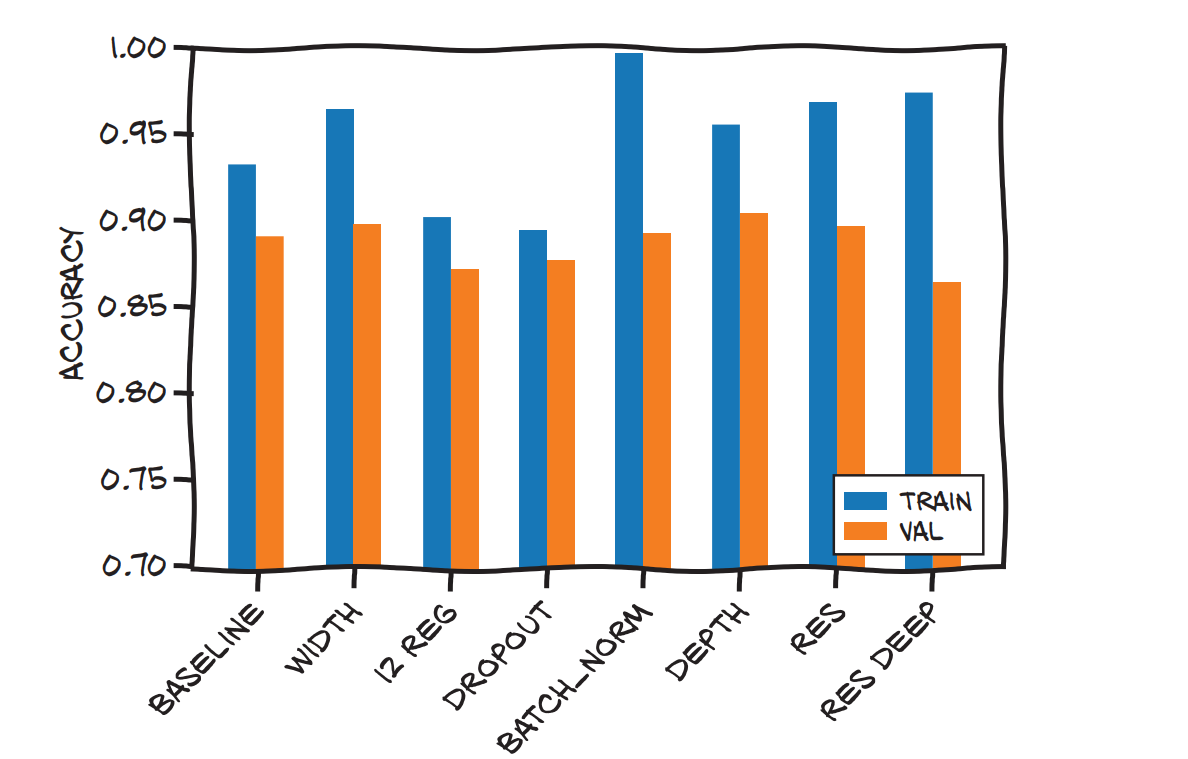

### 8.5.5 It’s already outdated


Creating bounding boxes around objects in an image is something a
model like ours can’t do.

#### Once trained, parameters of a model can be saved to disk and loaded back in with one line of code each